Notebook to analyse the output of the ABM and validate it.

## Content
* Loading of real data and model output
* Plot of runs and average value over real adoption
* Model validation based on average values
    * Macro-validation
        * Quantitative
    * Micro-validation
        * Quantitative
        * Qualitative

In [1]:
# TO SPECIFY
specific_model = 'all_adoption'
n_features = 18 # To calculate the adjusted R2 scores

# The following variables have to have the same values used to run the ABM.
n_runs = 25
start_year = 1996
stop_year = 2021

In [2]:
cd ..

C:\Users\giaco\pcf-project\abm


In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import csv

from abm.model import SBPAdoption

In [4]:
%matplotlib inline

mpl.rc('axes', labelsize=14)

tick_size = 11
mpl.rc('xtick', labelsize=tick_size)
mpl.rc('ytick', labelsize=tick_size)

plt.rcParams["font.family"] = "Calibri"

In [5]:
#Set size for the figures
fig_x = 8
fig_y = 5

In [6]:
# Line necessary to import agents in model, since the cwd of the notebook server is always the base path where you started the 
# server 
import sys
sys.path.append(".\municipalities_abm_all_feats")

In [7]:
# How to display floats
pd.options.display.float_format = '{:.6f}'.format
#np.set_printoptions(precision=6)
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

In [8]:
# Where to save the figures
PROJECT_ROOT_DIR = "model_validation"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "output", specific_model)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=False, fig_extension="jpeg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Real data loading

In [9]:
path_to_adoption_port_real = "./model_validation/data/SBP yearly adoption - Portugal.csv"
yearly_adoption_portugal_real = pd.read_csv(path_to_adoption_port_real, index_col=0)
yearly_adoption_portugal_real.drop(1995, inplace=True)

In [10]:
path_to_adoption_munic_real = "./model_validation/data/SBP yearly adoption - Municipalities.csv"
munic_yearly_adoption_real = pd.read_csv(path_to_adoption_munic_real, index_col=['Municipality', 'Year'])

# Load model output

In [11]:
path_to_model_results = os.path.join("./model_validation/output", specific_model)

In [12]:
munic_yearly_adoption = pd.read_csv(os.path.join(path_to_model_results, "output\municipalities_yearly_adoption.csv"),
                                   index_col=['Municipality', 'Year'])
yearly_adoption_portugal_pred = pd.read_csv(os.path.join(path_to_model_results, "output\portugal_yearly_adoption.csv"),
                                           index_col=['Year'])
cumulative_adoption_portugal_pred = pd.read_csv(os.path.join(path_to_model_results, "output\portugal_cumulative_adoption.csv"),
                                               index_col=['Year'])

# Plot of runs and average value over real adoption

In [13]:
import scipy.stats as st

def plot_adoption_trend_multiple_runs(predicted_adoption, real_adoption, max_y, fig_title, confidence=0.95):
    """
    Function to plot all the predicted adoptions, the average predicted and the real, in the same graph and save the figure.
    The predicted adoption and real adoption must be pandas Series or DataFrame with as index the years.
    """
    # Base figure
    fig_pr, ax_pr = plt.subplots()
    fig_pr.set_size_inches(fig_x, fig_y)
    ax_pr.set_xlabel("Years", fontsize=16)
    ax_pr.set_ylabel("Area installed [ha]", fontsize=16)
    #ax_pr.set_title(fig_title, fontsize=18)
    ax_pr.set_xlim(predicted_adoption.index[0], predicted_adoption.index[-1])
    xticks = [year for year in predicted_adoption.index if year%2 == 0]
    ax_pr.set_xticks(xticks)
    ax_pr.set_ylim(0, max_y)
    ax_pr.grid(True)

    # Plot adoptions
    for col in predicted_adoption.columns:
        ax_pr.plot(predicted_adoption.index, predicted_adoption[col].values, 'b:', linewidth=1, alpha=0.1)
    ci = []
    for index, row in predicted_adoption.iterrows():
        #m, se = np.mean(row), scipy.stats.sem(row)
        #ci.append(se * scipy.stats.t.ppf((1 + confidence) / 2., len(row)-1))
        ci.append(1.96 * np.std(row)/np.sqrt(n_runs))
    ci = np.array(ci)
    pred_adoption_av = predicted_adoption.mean(axis=1)
    pred_vals = pred_adoption_av.values
    ax_pr.plot(real_adoption.index, real_adoption.values, 'r--', linewidth=2, marker='.', markersize=9,
               label='Observed')
    ax_pr.plot(pred_adoption_av.index, pred_vals, 'b--', linewidth=2, marker='.', markersize=9,
               label='Estimated')    
    ax_pr.legend(loc='best', fontsize=12)
    
    ax_pr.fill_between(pred_adoption_av.index, (pred_vals-ci), (pred_vals+ci), color='b', alpha=.1)
    
    save_fig((fig_title))  

#### Plot predicted vs real adoption in Portugal

Saving figure Yearly SBP adoption in Portugal


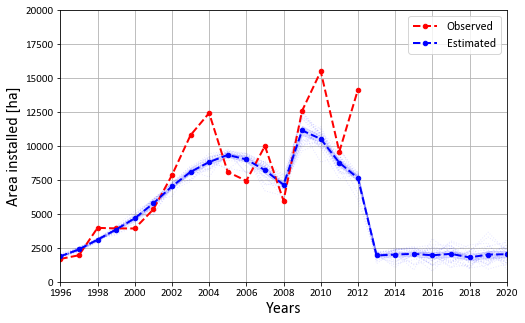

In [14]:
title = "Yearly SBP adoption in Portugal"
plot_adoption_trend_multiple_runs(yearly_adoption_portugal_pred, yearly_adoption_portugal_real, 20000, title, confidence=0.95)

#### Plot predicted vs real cumulative adoption in Portugal

In [15]:
cumulative_adoption_portugal_real = yearly_adoption_portugal_real.cumsum()

Saving figure Cumulative SBP adoption in Portugal


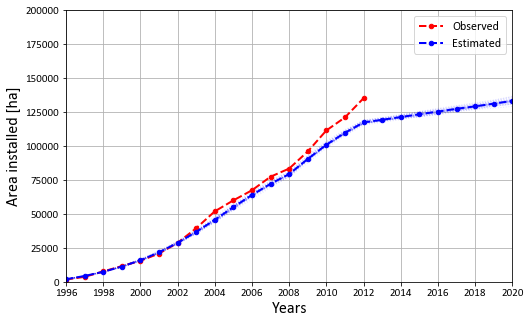

In [16]:
title = "Cumulative SBP adoption in Portugal"
plot_adoption_trend_multiple_runs(cumulative_adoption_portugal_pred, cumulative_adoption_portugal_real, 200000, title)

# Model validation based on average values

In [17]:
munic_yearly_adoption_av = munic_yearly_adoption.mean(axis=1)
munic_yearly_adoption_av.name = "predicted_adoption"

In [18]:
yearly_adoption_portugal_pred_av = yearly_adoption_portugal_pred.mean(axis=1)

In [19]:
cumulative_adoption_portugal_pred_av = cumulative_adoption_portugal_pred.mean(axis=1)

## Macro-validation

### Quantitative

In [21]:
def adjusted_r2(r2, n, p):
    return 1-(1-r2)*(n-1)/(n-p-1)

In [22]:
real_for_macro_metrics = yearly_adoption_portugal_real
pred_for_macro_metrics = yearly_adoption_portugal_pred_av_untill_2012

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(real_for_macro_metrics.values, pred_for_macro_metrics))
rrmse = rmse / real_for_macro_metrics.values.std()
mae = mean_absolute_error(real_for_macro_metrics.values, pred_for_macro_metrics)
r2 = r2_score(real_for_macro_metrics.values, pred_for_macro_metrics)
adj_r2 = adjusted_r2(r2, len(munic_yearly_adoption_av), n_features)
print("Cumulative adoption score:")
rmse_str = "RMSE: " + str(rmse)
print(rmse_str)
rrmse_str = "Relative RMSE: " + str(rrmse)
print(rrmse_str)
mae_str = "MAE: " + str(mae)
print(mae_str)
adj_r2_str = "Adjusted R2: " + str(adj_r2)
print(adj_r2_str)
print(r2)

with open(os.path.join('model_validation/output', specific_model, 'Macro-validation metrics.csv'),
          "w+", newline ='') as file:
    to_print = [[rmse_str], [rrmse_str], [mae_str], [adj_r2_str],]
    wr = csv.writer(file)
    wr.writerows(to_print)

Cumulative adoption score:
RMSE: 2440.3124242739937
Relative RMSE: 0.5949859802571061
MAE: 1730.354732553632
Adjusted R2: 0.6450689856866236
0.6459916832974903


## Micro-validation

Create dataframe with both real and predicted adoption between the starting year of the simulation and 2012.

### Quantitative

In [24]:
start_year = 1996

In [25]:
munic_adoption_real_pred = pd.concat([munic_yearly_adoption_real['adoption_in_year'], munic_yearly_adoption_av],
                                      axis=1, join='inner')
final_year_val = 2012
to_drop = munic_adoption_real_pred.loc[(munic_adoption_real_pred.index.get_level_values(1) < start_year)
                                       | (munic_adoption_real_pred.index.get_level_values(1) > final_year_val)].index
munic_adoption_real_pred.drop(to_drop, inplace=True)

In [26]:
from IPython.display import display

def get_yearly_and_cumul_rmse(adoption_rp):
    years = adoption_rp.index.get_level_values(1).unique()
    rmse_pd = pd.DataFrame(index=['RMSE on year', 'Relative RMSE on year', 'RMSE till year', 'Relative RMSE till year'],
                           columns=years)
    for year in years:
        real = adoption_rp.loc[(slice(None), year),'adoption_in_year'].values
        pred = adoption_rp.loc[(slice(None), year),'predicted_adoption'].values
        y_mse = mean_squared_error(real, pred)
        rmse_pd.loc['RMSE on year', year] = np.sqrt(y_mse)
        rmse_pd.loc['Relative RMSE on year', year] = np.sqrt(y_mse) / real.std()
        
        real_c = adoption_rp.loc[(slice(None), np.arange(start_year, year+1)),'adoption_in_year'].values
        pred_c = adoption_rp.loc[(slice(None), np.arange(start_year, year+1)),'predicted_adoption'].values
        y_mse_c = mean_squared_error(real_c, pred_c)
        rmse_pd.loc['RMSE till year', year] = np.sqrt(y_mse_c)
        rmse_pd.loc['Relative RMSE till year', year] = np.sqrt(y_mse_c) / real_c.std()
    
    display(rmse_pd)
    rmse_pd.T[['RMSE on year', 'RMSE till year']].plot()
    rmse_pd.T[['Relative RMSE on year', 'Relative RMSE till year']].plot()

In [27]:
def micro_validation(pred_adoption_runs, adoption_rp):
    real = adoption_rp['adoption_in_year'].values
    
    rmses = []
    rrmses = []
    maes = []
    adj_r2s = []
    
    for (_, pred) in pred_adoption_runs.iteritems(): 
        mse = mean_squared_error(real, pred)
        rmse = np.sqrt(mse)
        rrmse = rmse / real.std()
        rmses.append(rmse)
        rrmses.append(rrmse)
        
        mae = mean_absolute_error(real, pred)
        maes.append(mae)

        r2 = r2_score(real, pred)
        adj_r2 = adjusted_r2(r2, len(real), n_features)
        adj_r2s.append(adj_r2)
        
    pred = adoption_rp['predicted_adoption'].values
    mse = mean_squared_error(real, pred)
    rmse = np.sqrt(mse)
    rrmse = rmse / real.std()
    rmse_str = "Average total RMSE: " + str(rmse)
    rmse_str_2 = "Total RMSE standard deviation: " + str(np.std(rmses))
    print(rmse_str)
    print(rmse_str_2)
    rrmse_str = "Average total relative RMSE: " + str(rrmse)
    rrmse_str_2 = "Total relative RMSE standard deviation: " + str(np.std(rrmses))
    print(rrmse_str)
    print(rrmse_str_2)
    mae = mean_absolute_error(real, pred)
    mae_str = "Average total MAE: " + str(mae)
    mae_str_2 = "Total MAE standard deviation: " + str(np.std(maes))
    print(mae_str)
    print(mae_str_2)
    r2 = r2_score(real, pred)
    adj_r2 = adjusted_r2(r2, len(real), n_features)
    adj_r2_str = "Average total adjusted R2 score: " + str(adj_r2)
    adj_r2_str_2 = "Total adjusted R2 score standard deviation: " + str(np.std(adj_r2))
    print(adj_r2_str)
    print(adj_r2_str_2)
    
    with open(os.path.join('model_validation/output', specific_model, 'Micro-validation metrics and non adopters.csv'),
              "w+", newline ='') as file:
        to_print = [[rmse_str], [rmse_str_2], [rrmse_str], [rrmse_str_2],
                    [mae_str], [mae_str_2], [adj_r2_str], [adj_r2_str_2]]
        wr = csv.writer(file)
        wr.writerows(to_print)
        
    get_yearly_and_cumul_rmse(adoption_rp)

Average total RMSE: 0.008489152530176996
Total RMSE standard deviation: 6.692916305948686e-05
Average total relative RMSE: 0.8417450578136826
Total relative RMSE standard deviation: 0.0066363859088010135
Average total MAE: 0.001904137098288584
Total MAE standard deviation: 4.3686572647811834e-05
Average total adjusted R2 score: 0.28874593454125763
Total adjusted R2 score standard deviation: 0.0


Year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
RMSE on year,0.003615,0.004398,0.002321,0.004612,0.005223,0.003983,0.005317,0.004497,0.006141,0.008327,0.003209,0.021709,0.007488,0.005591,0.012073,0.010255,0.012146
Relative RMSE on year,0.963753,0.934650,0.802173,0.899515,0.877780,0.787755,0.771470,0.565864,0.617138,0.726663,0.436606,0.897744,0.797498,0.883600,0.929086,0.941042,0.944034
RMSE till year,0.003615,0.004025,0.003549,0.003843,0.004156,0.004127,0.004317,0.004340,0.004576,0.005077,0.004937,0.007849,0.007822,0.007684,0.008052,0.008207,0.008489
Relative RMSE till year,0.963753,0.945834,0.919168,0.911713,0.899213,0.877267,0.848111,0.774003,0.727733,0.725508,0.701717,0.803292,0.802495,0.804962,0.820438,0.830182,0.841745


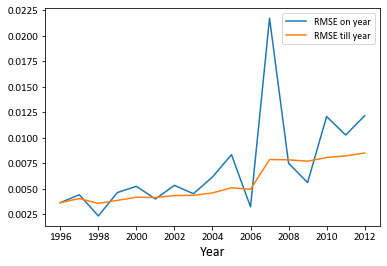

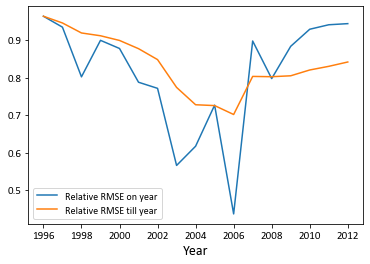

In [28]:
munic_yearly_adoption_untill_2012 = munic_yearly_adoption.loc[munic_yearly_adoption.index.get_level_values('Year') <= 2012]
micro_validation(munic_yearly_adoption_untill_2012, munic_adoption_real_pred)

### Qualitative

In [29]:
munic_adoption_real_pred_dist = munic_adoption_real_pred.copy()
munic_adoption_real_pred_dist.rename(columns={"adoption_in_year": "Observed adoption",
                                              "predicted_adoption": "Predicted adoption"}, inplace=True)

#### Number of predicted adopters over time

In [30]:
mask_real = munic_adoption_real_pred_dist['Observed adoption'] > 0
real_yearly_adopters = (munic_adoption_real_pred_dist['Observed adoption'] > 0).astype(int).groupby('Year').sum()

# For prediction cannot use the averaged data --> need to do the average of the adopters in each run
pred_yearly_adopters = (munic_yearly_adoption > 0).astype(int).groupby('Year').sum()
pred_yearly_adopters_av = pred_yearly_adopters.mean(axis=1)

Saving figure Number of municipalities with adoption over time


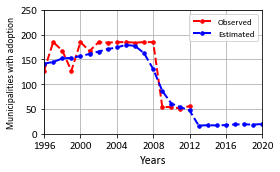

In [31]:
# Base figure
fig_title = 'Number of municipalities with adoption over time'
fig_ad, ax_ad = plt.subplots()
fig_ad.set_size_inches(4, 2.5)
ax_ad.set_xlabel("Years", fontsize=12)
ax_ad.set_ylabel("Municipalities with adoption", fontsize=9.5)
ax_ad.set_xlim(pred_yearly_adopters.index[0], pred_yearly_adopters.index[-1])
xticks = [year for year in pred_yearly_adopters.index if year%4 == 0]
ax_ad.set_xticks(xticks)
ax_ad.set_ylim(0, 250)
ax_ad.grid(True)

# Plot adoptions
ax_ad.plot(real_yearly_adopters.index, real_yearly_adopters.values, 'r--', linewidth=2, marker='.', markersize=7,
           label='Observed')
ax_ad.plot(pred_yearly_adopters_av.index, pred_yearly_adopters_av.values, 'b--', linewidth=2, marker='.', markersize=7,
           label='Estimated')
ax_ad.legend(loc='best', fontsize=9)

save_fig((fig_title), tight_layout=True)

#### Average adoption of only adopters over time

In [32]:
pred_av_yearly_adoption = (yearly_adoption_portugal_pred_av / pred_yearly_adopters_av)
real_av_yearly_adoption = (yearly_adoption_portugal_real['Yearly adoption'] / real_yearly_adopters)

Saving figure Average adoption of municipalities adopting over time


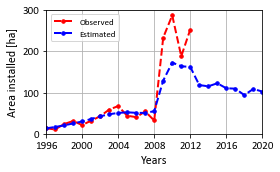

In [33]:
# Base figure
fig_title = 'Average adoption of municipalities adopting over time'
fig_ad, ax_ad = plt.subplots()
fig_ad.set_size_inches(4, 2.5)
ax_ad.set_xlabel("Years", fontsize=12)
ax_ad.set_ylabel("Area installed [ha]", fontsize=12)
#ax_ad.set_title(fig_title, fontsize=18)
ax_ad.set_xlim(pred_av_yearly_adoption.index[0], pred_av_yearly_adoption.index[-1])
xticks = [year for year in pred_av_yearly_adoption.index if year%4 == 0]
ax_ad.set_xticks(xticks)
ax_ad.set_ylim(0, 300)
ax_ad.grid(True)

# Plot adoptions
ax_ad.plot(real_av_yearly_adoption.index, real_av_yearly_adoption.values, 'r--', linewidth=2, marker='.', markersize=7,
           label='Observed')
ax_ad.plot(pred_av_yearly_adoption.index, pred_av_yearly_adoption.values, 'b--', linewidth=2, marker='.', markersize=7,
           label='Estimated')
ax_ad.legend(loc='best', fontsize=9)

save_fig((fig_title), tight_layout=True)

#### Ditribution of adoption in each year in each municipality

In [34]:
num_0_real = (munic_adoption_real_pred_dist["Observed adoption"] == 0).astype(int).sum()
num_0_real_str = "Total OBSERVED number of times any municipality does NOT adopt 1996-2012: " + str(num_0_real)
print(num_0_real_str)

pred_yearly_non_adopters = (munic_yearly_adoption == 0).astype(int).groupby('Year').sum()
pred_yearly_non_adopters_av = pred_yearly_adopters.mean(axis=1)
num_0_pred = round(pred_yearly_non_adopters_av.sum(), 0).astype(int)
num_0_pred_str = "Average total PREDICTED number of times any municipality does NOT adopt 1996-2012: " + str(num_0_pred)
print(num_0_pred_str)

with open(os.path.join('model_validation/output', specific_model, 'Micro-validation metrics and non adopters.csv'),
          "a", newline ='') as file:
    to_print = [" ", [num_0_real_str], [num_0_pred_str]]
    wr = csv.writer(file)
    wr.writerows(to_print)

Total OBSERVED number of times any municipality does NOT adopt 1996-2012: 2242
Average total PREDICTED number of times any municipality does NOT adopt 1996-2012: 2463


Saving figure Distribution of municipalities' adoption


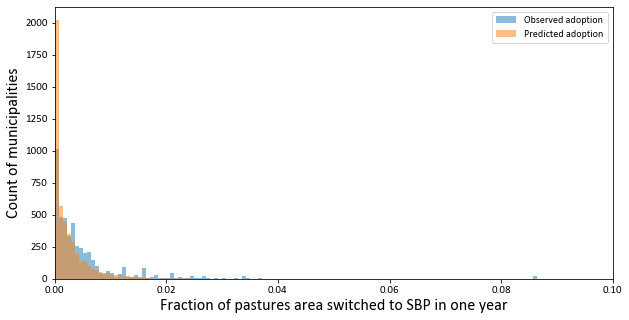

In [35]:
fig_title = "Distribution of municipalities' adoption"
munic_adoption_real_pred_dist.replace(0, None, inplace=True) # To avoid plotting 0s
ax = munic_adoption_real_pred_dist.plot.hist(figsize=(10, 5), bins=500, alpha=0.5) 
ax.set_xlabel("Fraction of pastures area switched to SBP in one year", fontsize=16)
ax.set_ylabel("Count of municipalities", fontsize=16)
ax.set_xlim(0, 0.1)
#ax.set_title("Distribution of municipalities' adoption", fontsize=18)
ax_ad.legend(loc='best', fontsize=12)
save_fig((fig_title))

In [36]:
munic_adoption_real_pred_dist['Predicted adoption'].describe()

count   4709.000000
mean       0.002461
std        0.004073
min        0.000000
25%        0.000217
50%        0.001138
75%        0.003231
max        0.091519
Name: Predicted adoption, dtype: float64

#### Map based on adoption level for each municipality at the end of the simulation

In [37]:
from shapely import wkt

year_for_map = 2012

In [38]:
path_pred_for_map = os.path.join(path_to_model_results, "output/adoption_pred_for_map.csv")
pred_for_map = pd.read_csv(path_pred_for_map, index_col=0)

pred_for_map['geometry'] = pred_for_map['geometry'].apply(wkt.loads)
pred_for_map = gpd.GeoDataFrame(pred_for_map, crs='epsg:4326')

In [39]:
pred_for_map = gpd.GeoDataFrame(pred_for_map)

In [40]:
# Collect observed adoption in year
geometry = pred_for_map['geometry']
munic_map_adoption_real = munic_yearly_adoption_real.loc[munic_yearly_adoption_real.index.get_level_values(1) == year_for_map]
munic_map_adoption_real.index = munic_map_adoption_real.index.droplevel(1)

real_for_map = pd.concat([munic_map_adoption_real['tot_cumul_adoption_until_year_ha'], geometry], axis=1)
real_for_map = gpd.GeoDataFrame(real_for_map)

Plot of area adopted in hectares

In [41]:
import contextily as ctx
import matplotlib

def plot_maps_with_0s(geodata, column_data, leg_label, fig_title):
    """
    To plot maps side by side.
    Inputs to be given as lists of two elements, the first referring to the predicted adoption and the second to the
    observed one.
    
    For additional options for plotting with geopandas see https://geopandas.org/mapping.html
    For different backgrounds see https://contextily.readthedocs.io/en/latest/providers_deepdive.html
    """
    fig, axis = plt.subplots(ncols=len(geodata), figsize=(15, 8))

    for i in range(len(geodata)):
        geodata_0 = geodata[i].loc[geodata[i][column_data[i]] == 0]
        geodata_0.crs = "EPSG:3857"
        geodata_no_0 = geodata[i].loc[geodata[i][column_data[i]] != 0]
        geodata_no_0.crs = "EPSG:3857"
        transparency = 0.8
        if i == 0: # Legend scale based on predicted values
            sc_min = 10
            sc_max = max(geodata_no_0['Total cumulative adoption [ha]']) 
        geodata_no_0.plot(ax=axis[i], column=column_data[i],
                          cmap="OrRd", #cmap='coolwarm',
                          alpha=transparency, edgecolor='k',
                          legend=True, norm=matplotlib.colors.LogNorm(vmin=sc_min, vmax=sc_max),
                          legend_kwds={'label': leg_label[i]})
        geodata_0.plot(ax=axis[i], column=column_data[i],
                        color='k',
                        alpha=transparency, edgecolor='k',
                        legend=False)
        ctx.add_basemap(axis[i], source=ctx.providers.Stamen.Terrain)
        axis[i].axis('off')

    save_fig((fig_title))

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\geopandas\plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\geopandas\plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


Saving figure Predicted vs observed adoption spatial distribution [ha]


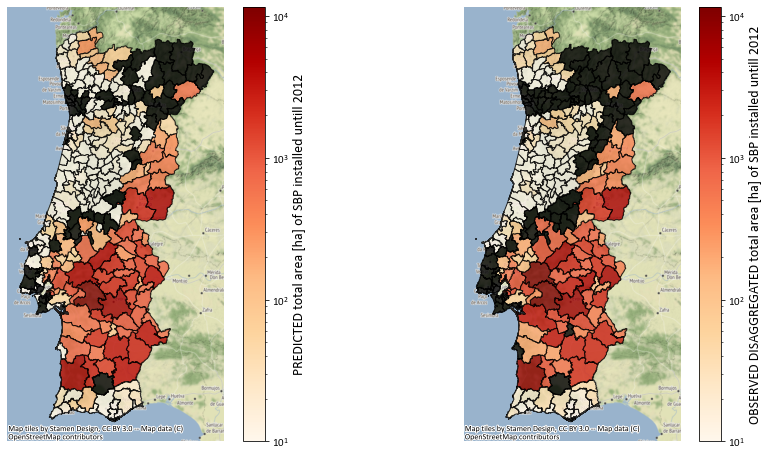

In [45]:
pred_leg_label = "PREDICTED total area [ha] of SBP installed untill " + str(year_for_map)
real_leg_label = "OBSERVED DISAGGREGATED total area [ha] of SBP installed untill " + str(year_for_map)
plot_maps_with_0s([pred_for_map, real_for_map], ['Total cumulative adoption [ha]', 'tot_cumul_adoption_until_year_ha'],
                [pred_leg_label, real_leg_label], "Predicted vs observed adoption spatial distribution [ha]")